
Forecasting Solar Energy Production


c:\Users\joshf\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\joshf\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\joshf\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\joshf\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  war


Forecasting Wind Energy Production


c:\Users\joshf\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\joshf\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\joshf\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


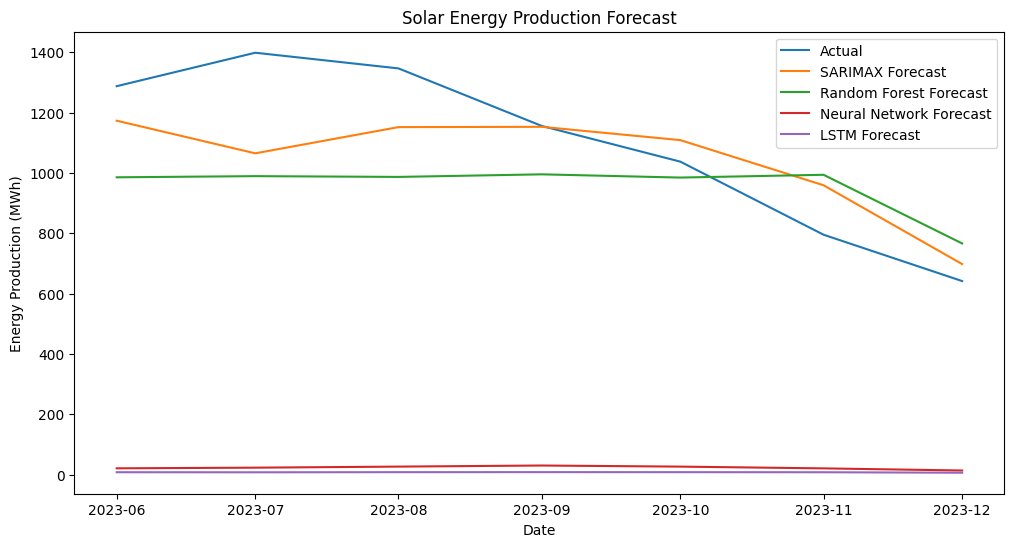

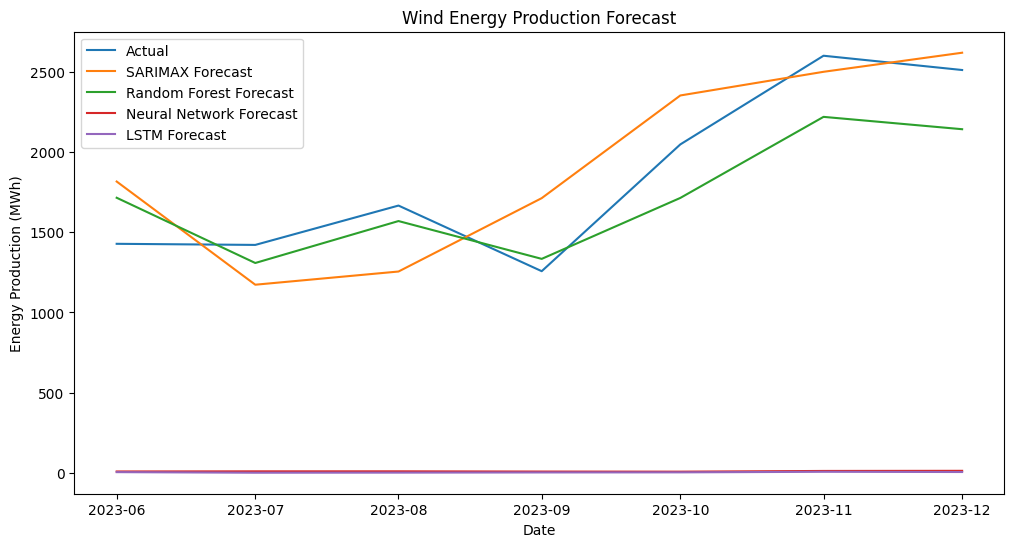

Forecasting and visualization complete. Check the '../docs/figures' directory for the generated PNG files.


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import json
import os

# Suppress FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

start_date = '2021-01-01'
end_date = '2023-12-31'
state_code = 'NY'  # New York

# Load data
merged_data = pd.read_csv(f'../data/{state_code}_renewable_energy_weather_data.csv')
merged_data['date'] = pd.to_datetime(merged_data['date'])

# Prepare data for forecasting
merged_data2 = merged_data.copy()
merged_data2['date'] = pd.to_datetime(merged_data2['date'])
merged_data2.set_index('date', inplace=True)

# Create features
def create_features(data, target, lag=3):
    for i in range(1, lag+1):
        data[f'{target}_lag_{i}'] = data[target].shift(i)
    
    # One-hot encode the month
    data = pd.get_dummies(data, columns=['month'], prefix='month')
    
    return data.dropna()

# Prepare data
solar_data = create_features(merged_data2[['SUN', 'temp', 'wind_speed', 'precipitation', 'month']], 'SUN')
wind_data = create_features(merged_data2[['WND', 'temp', 'wind_speed', 'precipitation', 'month']], 'WND')

# Split data
train_size = int(len(solar_data) * 0.8)
solar_train, solar_test = solar_data[:train_size], solar_data[train_size:]
wind_train, wind_test = wind_data[:train_size], wind_data[train_size:]

# Evaluation function
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{model_name} Performance:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"R-squared Score: {r2:.2f}")

# SARIMAX model
def fit_sarimax(train, test, target):
    exog_cols = [col for col in train.columns if col != target and not col.startswith(f'{target}_lag')]
    model = SARIMAX(train[target], exog=train[exog_cols], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    results = model.fit()
    forecast = results.forecast(steps=len(test), exog=test[exog_cols])
    return forecast

# Random Forest model
def fit_random_forest(train, test, target):
    features = [col for col in train.columns if col != target]
    X_train, y_train = train[features], train[target]
    X_test = test[features]
    
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    forecast = rf_model.predict(X_test)
    return forecast

# Update SimpleNN and LSTM classes to accept the new input size
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

def fit_nn(train, test, target, epochs=100):
    features = [col for col in train.columns if col != target]
    X_train, y_train = train[features].values, train[target].values
    X_test = test[features].values
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
    X_test_tensor = torch.FloatTensor(X_test_scaled)
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    model = SimpleNN(X_train.shape[1])
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())
    
    for epoch in range(epochs):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
    
    model.eval()
    with torch.no_grad():
        forecast = model(X_test_tensor).numpy().flatten()
    
    return forecast

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

def fit_lstm(train, test, target, epochs=100):
    features = [col for col in train.columns if col != target]
    X_train, y_train = train[features].values, train[target].values
    X_test = test[features].values
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    X_train_tensor = torch.FloatTensor(X_train_scaled).unsqueeze(1)
    y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
    X_test_tensor = torch.FloatTensor(X_test_scaled).unsqueeze(1)
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    model = LSTM(X_train.shape[1], 64, 2, 1)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())
    
    for epoch in range(epochs):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
    
    model.eval()
    with torch.no_grad():
        forecast = model(X_test_tensor).numpy().flatten()
    
    return forecast

# Fit and evaluate models
def get_mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

# fit_and_evaluate_all function
def fit_and_evaluate_all(train, test, target):
    sarimax_forecast = fit_sarimax(train, test, target)
    rf_forecast = fit_random_forest(train, test, target)
    nn_forecast = fit_nn(train, test, target)
    lstm_forecast = fit_lstm(train, test, target)
    
    mae_values = {
        'SARIMAX': get_mae(test[target], sarimax_forecast),
        'Random Forest': get_mae(test[target], rf_forecast),
        'Neural Network': get_mae(test[target], nn_forecast),
        'LSTM': get_mae(test[target], lstm_forecast)
    }
    
    forecasts = {
        'SARIMAX': sarimax_forecast,
        'Random Forest': rf_forecast,
        'Neural Network': nn_forecast,
        'LSTM': lstm_forecast
    }
    
    return mae_values, forecasts

# Run the models and get MAE values and forecasts
print("\nForecasting Solar Energy Production")
solar_mae, solar_forecasts = fit_and_evaluate_all(solar_train, solar_test, 'SUN')

print("\nForecasting Wind Energy Production")
wind_mae, wind_forecasts = fit_and_evaluate_all(wind_train, wind_test, 'WND')

# Ensure the directory exists
os.makedirs('../docs/figures', exist_ok=True)

# Save MAE values to a file
with open('../docs/mae_values.json', 'w') as f:
    json.dump({'solar': solar_mae, 'wind': wind_mae}, f)

# Plotting results
def plot_forecasts(test, actual, forecasts, title):
    plt.figure(figsize=(12,6))
    plt.plot(test.index, actual, label='Actual')
    for model, forecast in forecasts.items():
        plt.plot(test.index, forecast, label=f'{model} Forecast')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Energy Production (MWh)')
    plt.legend()
    plt.savefig(f'../docs/figures/{title.replace(" ", "_")}.png')
    plt.show()

plot_forecasts(solar_test, solar_test['SUN'], solar_forecasts, 'Solar Energy Production Forecast')
plot_forecasts(wind_test, wind_test['WND'], wind_forecasts, 'Wind Energy Production Forecast')

print("Forecasting and visualization complete. Check the '../docs/figures' directory for the generated PNG files.")

In [3]:
# Assuming you have the actual and forecasted values stored
# If not, you'll need to run your models again to get these values

# solar_test: your test data
# solar_forecasts: dictionary of forecasts from different models

solar_df = solar_test[['SUN']].copy()
for model, forecast in solar_forecasts.items():
    solar_df[f'{model}_Forecast'] = forecast

solar_df.to_csv('../docs/figures/solar_energy_forecast.csv')

In [4]:
# Similar to solar, but for wind data
wind_df = wind_test[['WND']].copy()
for model, forecast in wind_forecasts.items():
    wind_df[f'{model}_Forecast'] = forecast

wind_df.to_csv('../docs/figures/wind_energy_forecast.csv')